This is the implementation of Visual Transformer

In [1]:
import os
import warnings
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
from torchinfo import summary


In [2]:
seed = 39
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
warnings.filterwarnings("ignore")


In [3]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

def train_loop(dataloader, model, loss_fn, optimizer, device):
    train_loss = 0
    samples = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item() * len(y)
        samples += len(y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= samples
    return train_loss

def test_loop(dataloader, model, loss_fn, device):
    test_loss = 0
    test_accuracy = 0
    samples = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            loss = loss_fn(pred, y)
            test_loss += loss.item() * len(y)
            _, preds = torch.max(pred, 1)
            test_accuracy += accuracy(y, preds) * len(y)
            samples += len(y)

    test_loss /= samples
    test_accuracy /= samples
    return test_loss, test_accuracy


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
'''
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])'''

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [6]:
TRAIN_DIR = 'archive/Training'
TEST_DIR = 'archive/Testing'

# Load the training dataset
full_train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

classes = full_train_dataset.classes
print(f"Number of classes: {len(classes)}, Classes: {classes}")
len(full_train_dataset), len(test_dataset), classes



Number of classes: 4, Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


(2870,
 394,
 ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

In [15]:
import os

dataset_dir = "archive/Testing"  # or your dataset directory
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

class_counts = {}
for c in classes:
    class_path = os.path.join(dataset_dir, c)
    # Count only image files (assuming JPEG or PNG)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[c] = len(images)

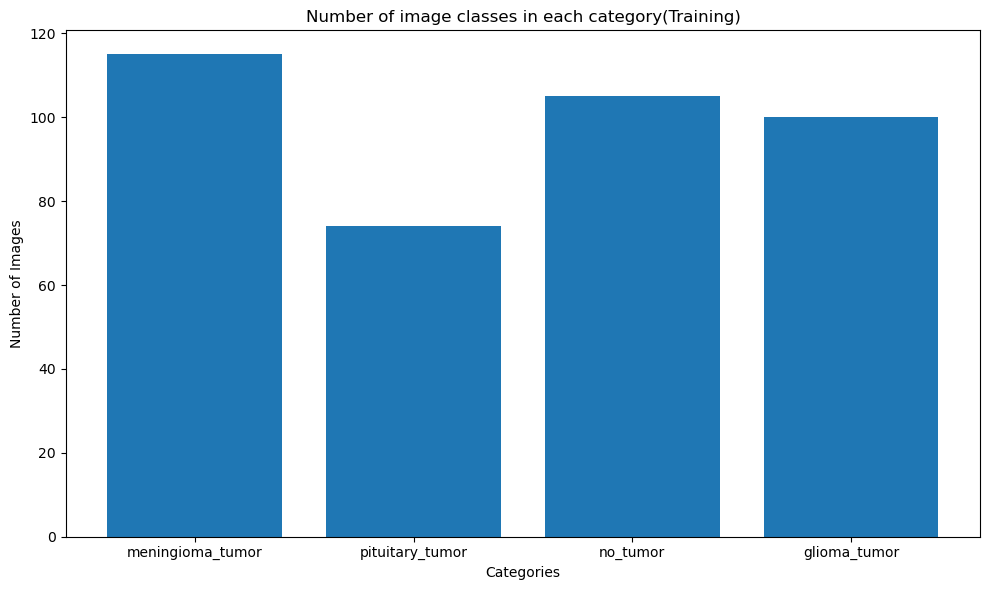

In [16]:
import matplotlib.pyplot as plt

# Extract class names and corresponding counts
class_names = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Number of image classes in each category(Training)")
plt.tight_layout()
plt.show()

In [7]:
BATCH_SIZE = 16

val_ratio = 0.1
train_size = int((1 - val_ratio) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


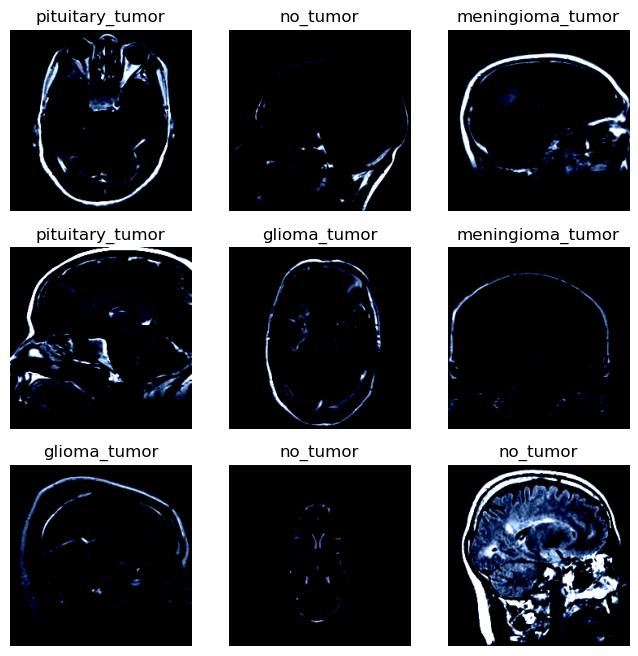

In [8]:
fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    image, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(classes[label])
    plt.axis('off')
plt.show()


In [9]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load pre-trained ViT model
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

for param in model.encoder.parameters():
    param.requires_grad = True

# Modify the classifier head
num_classes = len(classes)
#model.heads = nn.Linear(model.hidden_dim, num_classes)

model.heads = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout to prevent overfitting
    nn.Linear(model.hidden_dim, num_classes)
).to(device)

model = model.to(device)

#model summary
summary(model, input_size=(1, 3, 224, 224), device=device.type)


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [10]:
import torch.nn as nn
learning_rate = 0.000005
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
from tqdm.auto import tqdm
best_val_acc = 0
EPOCHS = 30
train_losses = []
val_losses = []
val_accuracies = []
test_accuracies = []
best_model_path = "best_model_final.pth"
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn, device)
    loc_test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    #print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%\n")

    print(f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Accuracy: {val_accuracy:.2f}% | "
          f"Test Accuracy: {test_accuracy:.2f}%\n")
    
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {best_val_acc :.2f}%")

model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)
print(f"Best Model Test Accuracy: {test_acc:.2f}%")

Epoch 1/30
Train Loss: 0.8065 | Val Loss: 0.3724 | Val Accuracy: 86.41% | Test Accuracy: 60.66%

New best model saved with validation accuracy: 86.41%
Epoch 2/30
Train Loss: 0.3300 | Val Loss: 0.2016 | Val Accuracy: 91.99% | Test Accuracy: 73.86%

New best model saved with validation accuracy: 91.99%
Epoch 3/30
Train Loss: 0.1988 | Val Loss: 0.2108 | Val Accuracy: 93.03% | Test Accuracy: 76.65%

New best model saved with validation accuracy: 93.03%
Epoch 4/30
Train Loss: 0.1370 | Val Loss: 0.1378 | Val Accuracy: 94.43% | Test Accuracy: 77.41%

New best model saved with validation accuracy: 94.43%
Epoch 5/30
Train Loss: 0.1051 | Val Loss: 0.1000 | Val Accuracy: 96.17% | Test Accuracy: 79.70%

New best model saved with validation accuracy: 96.17%
Epoch 6/30
Train Loss: 0.0706 | Val Loss: 0.1070 | Val Accuracy: 95.82% | Test Accuracy: 80.96%

Epoch 7/30
Train Loss: 0.0697 | Val Loss: 0.1245 | Val Accuracy: 95.47% | Test Accuracy: 79.70%

Epoch 8/30
Train Loss: 0.0579 | Val Loss: 0.1556 | 

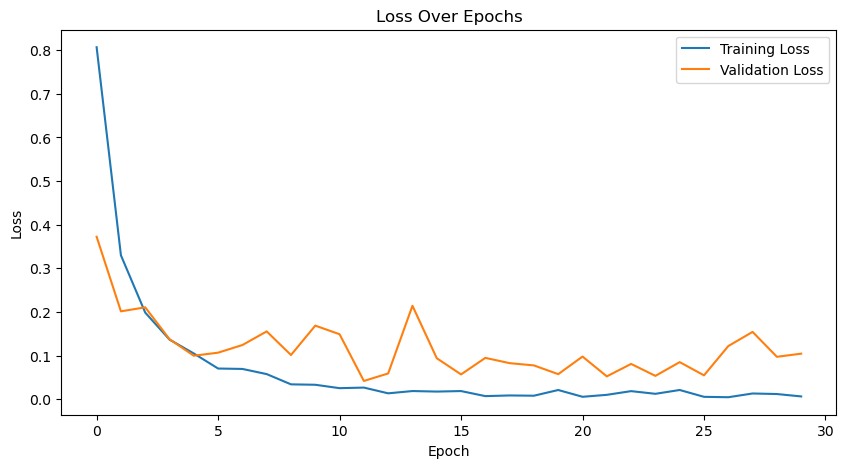

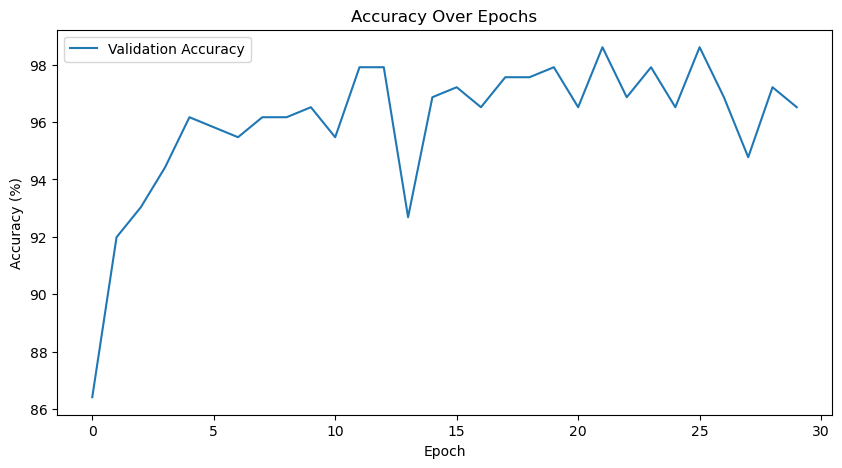

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


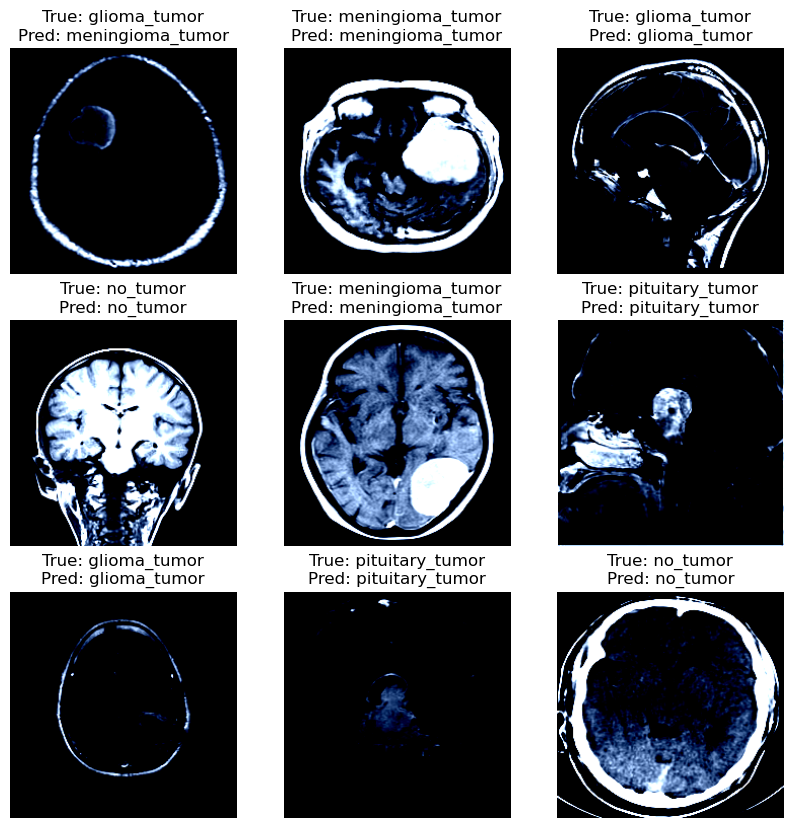

In [13]:
# Function to display predictions
def display_predictions(model, dataset, classes):
    model.eval()
    fig = plt.figure(figsize=(10, 10))
    rows, cols = 3, 3
    for i in range(1, rows * cols + 1):
        idx = torch.randint(0, len(dataset), size=(1,)).item()
        image, label = dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, predicted = torch.max(output, 1)
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"True: {classes[label]}\nPred: {classes[predicted.item()]}")
        ax.axis('off')
    plt.show()

# Display predictions on test dataset
display_predictions(model, test_dataset, classes)


In [14]:
!pip install tabulate

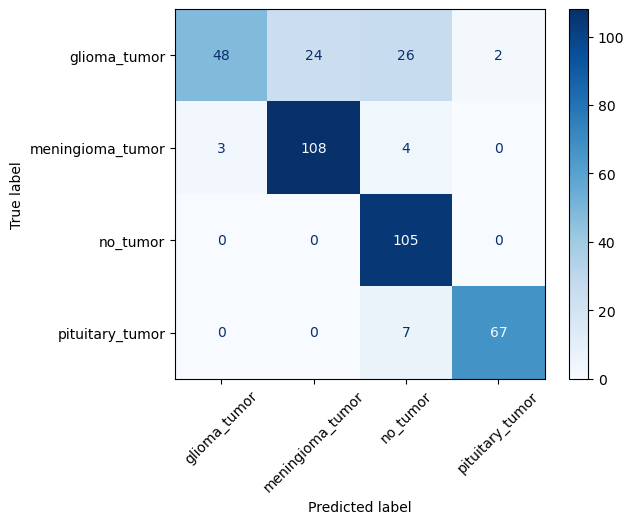

Class             Precision           Recall              F1-Score              Support
----------------  ------------------  ------------------  ------------------  ---------
glioma_tumor      0.9411764705882353  0.48                0.6357615894039734   100.0000
meningioma_tumor  0.8181818181818182  0.9391304347826087  0.8744939271255062   115.0000
no_tumor          0.7394366197183099  1.0                 0.8502024291497975   105.0000
pituitary_tumor   0.9710144927536232  0.9054054054054054  0.937062937062937     74.0000
accuracy          -                   -                   -                      0.8325
macro avg         0.8674523503104966  0.8311339600470035  0.8243802206855535   394.0000
weighted avg      0.8571179535124955  0.8324873096446701  0.8191798806173011   394.0000
Classification Metrics:
{'glioma_tumor': {'precision': 0.9411764705882353, 'recall': 0.48, 'f1-score': 0.6357615894039734, 'support': 100.0}, 'meningioma_tumor': {'precision': 0.8181818181818182, 'recall': 0.

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Get predictions and true labels
model.eval()
y_preds = []
y_true = []
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.cpu().numpy())
        y_true.extend(y.numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

report = classification_report(y_true, y_preds, target_names=classes, output_dict=True)
from tabulate import tabulate
rows = []
for label, metrics in report.items():
    if isinstance(metrics, dict):  # Ignore accuracy since it's not a dict
        rows.append([
            label,
            metrics['precision'],
            metrics['recall'],
            metrics['f1-score'],
            metrics['support']
        ])
    elif label == 'accuracy':  # Add accuracy row separately
        rows.append(['accuracy', '-', '-', '-', metrics])

# Define headers
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]

# Print the table
print(tabulate(rows, headers=headers, floatfmt=".4f"))
print("Classification Metrics:")
print(report)